## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import numpy as np
from numba import vectorize, int64, float32

A = np.array([2, 5, 10, 3, 8], dtype='float32')

@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_log(x):
    return np.log(x)

@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_exp(x):
    return np.exp(x)

print(vec_log(A))
print(vec_exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exercise 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

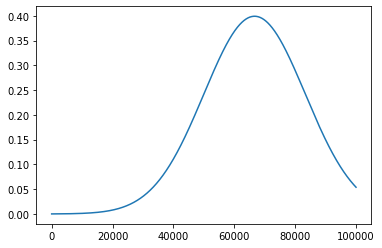

In [48]:
import numpy as np
from numba import vectorize, float32, jit, cuda
import matplotlib.pyplot as plt
@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_gaus(x):
    mean = 1.
    sigma = 1.
    return 1. / np.sqrt(2 * np.pi * sigma**2)* np.exp(- ((x - mean) / sigma)**2 / 2)

N = 100000
mesh = np.linspace(-3, 3, N, dtype='float32')
vec_gaus(mesh)
plt.plot(vec_gaus(mesh))
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

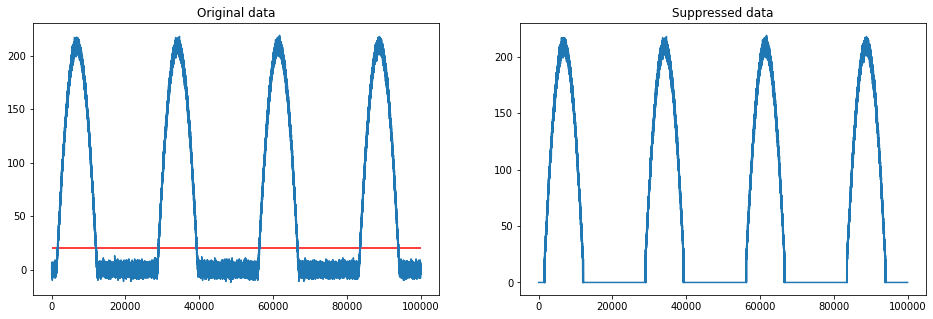

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

@vectorize([float32(float32, float32)], target='parallel', fastmath=True) 
def vec_supp(x, thresh):
    if x < thresh:
        return 0
    else: return x

fig, ax = plt.subplots(1,2, figsize = (16,5))
ax[0].hlines(20, 0, 100000, color = 'red')


ax[0].plot(data)
ax[0].set_title('Original data')


data_supp = vec_supp(data, 20)
ax[1].plot(data_supp)
ax[1].set_title('Suppressed data')
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
import numpy as np
import numba

X = np.random.rand(3, 3)
Y = np.random.rand(3, 3)

@numba.jit
def sigmoid_kernel(X,Y,a,c):
    return np.tanh(a * np.dot(X.T, Y) + c)

print(sigmoid_kernel(X, Y, 1, 1))

[[0.90025862 0.80448278 0.86496799]
 [0.9360488  0.82526956 0.93629632]
 [0.90221892 0.83555197 0.88217167]]


In [29]:
from numba import cuda
import os
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"

X = np.random.rand(3,3).astype('float64')
Y = np.random.rand(3,3).astype('float64')
res = np.zeros((3,3), dtype='float64')


@cuda.jit
def sigmoid_kernel(x, y, result, a, c):    
    
    row, col = cuda.grid(2)
    
    if row < result.shape[0] and col < result.shape[1]:
        tmp = 0.
        for k in range(x.shape[0]):
            tmp += x[k, row] * y[k, col]
        
        result[row, col] = math.tanh(a * tmp + c)

        
sigmoid_kernel[(1,1),(3,3)](X, Y, res, 1., 1.)

print(res)

TypeError: __init__() got an unexpected keyword argument 'debug'

## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [44]:
from numba import cuda
import numpy
import math
import os
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"

# CUDA kernel
@cuda.jit
def cosine_kernel(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = math.cos(io_array[x][y][z])

# Host code   
data = numpy.ones((256,256,256))

# Configure the blocks
threadsperblock = (8, 8, 8)
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

cosine_kernel[blockspergrid, threadsperblock](data)
print(data)

TypeError: __init__() got an unexpected keyword argument 'debug'

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [ ]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = 
B = 

# Configure the blocks
threadsperblock = 
blockspergrid_x = 
blockspergrid_y = 
blockspergrid = 

